In [1]:
import pandas as pd
import numpy as np
import sys
import re
df_ordered = pd.read_csv("../code/ordered.csv")
df_severeWeather = pd.read_csv("../code/severeWeather.csv")


# Capstone Project I Report: Data Storytelling Part 2

In the dataset, it seems that all the features in this dataset could affect sales record in some ways. For example, under heavy rains or high temperature people may delay their shopping to another day. Also, people tend to buy more things on weekends instead of weekdays. In order to answer which feature is more dominant in terms of determining people's shopping pattern, I list the following questions to be tested:
* Specific idea on item 5: Given above, among these factors, which one seems to be the most important one?
    + year
    + month
    + weekdays
    + rainfall/snowfall
    + tempature

## Specific idea on item 5: 

<h4> Question: Given above, among these factors, which one seems to be the most important one? 1. year 2. month 3. weekdays 4. rainfall/snowfall 5. tempature 
</h4>

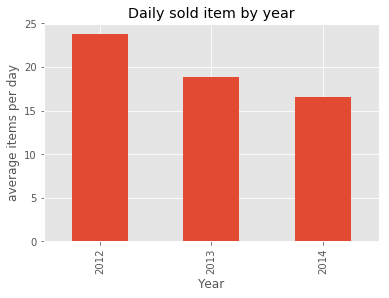

In [150]:
df_ordered['year'] = pd.to_datetime(df_ordered['date'], infer_datetime_format=True).dt.year

mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','year']]

count = data.groupby(['year']).aggregate(np.mean).unstack()
count.index = count.index.droplevel()
count.plot(kind='bar')
plt.title('Daily sold item by year')
plt.xlabel('Year')
plt.ylabel('average items per day')
plt.show()

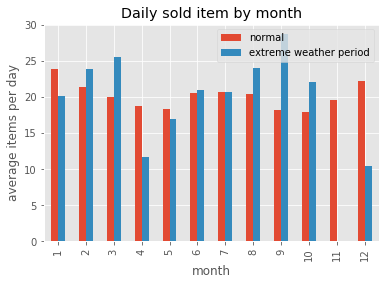

In [161]:
df_ordered['month'] = pd.to_datetime(df_ordered['date'], infer_datetime_format=True).dt.month

mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','month']]

count = data.groupby(['month']).aggregate(np.mean).unstack()
count.index = count.index.droplevel()


mask = ((df_ordered['item_nbr'] == 5) & (df_ordered['WEvent'] == 1))
data = df_ordered.loc[mask,['units','month']]

count_severe = data.groupby(['month']).aggregate(np.mean).unstack()
count_severe.index = count_severe.index.droplevel()

count = pd.concat([count, count_severe], axis=1)
count.columns = ['normal','extreme weather period']

count.plot(kind='bar')

plt.title('Daily sold item by month')
plt.xlabel('month')
plt.ylabel('average items per day')


plt.show()


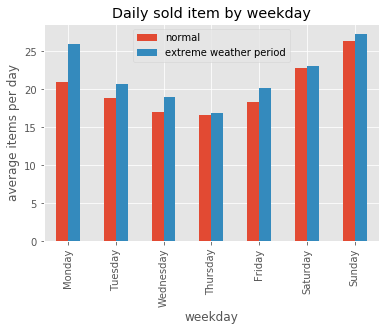

In [166]:
df_ordered['weekday'] = pd.to_datetime(df_ordered['date'], infer_datetime_format=True).dt.weekday

mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','weekday']]

count = data.groupby(['weekday']).aggregate(np.mean).unstack()
count.index = count.index.droplevel()


mask = ((df_ordered['item_nbr'] == 5) & (df_ordered['WEvent'] == 1))
data = df_ordered.loc[mask,['units','weekday']]

count_severe = data.groupby(['weekday']).aggregate(np.mean).unstack()
count_severe.index = count_severe.index.droplevel()

count = pd.concat([count, count_severe], axis=1)
count.columns = ['normal','extreme weather period']
import calendar
count.index = list(calendar.day_name)

count.plot(kind='bar')

plt.title('Daily sold item by weekday')
plt.xlabel('weekday')
plt.ylabel('average items per day')


plt.show()

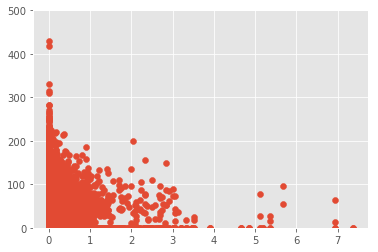

In [11]:
mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','preciptotal']]

plt.scatter(data['preciptotal'],data['units'])
plt.ylim(0,500)
plt.show()

[0.0, 0.02, 0.070000000000000007, 0.19, 0.46000000000000002, 7.3600000000000003]

for preciptotal range in 0.0
number of observations: 31569
value,  20.9697171276
99% interval,  [ 20.4870593   21.45644826]

for preciptotal range in 0.0 to 0.02
number of observations: 1354
value,  16.6632200886
99% interval,  [ 14.50291728  18.90326071]

for preciptotal range in 0.02 to 0.07
number of observations: 1526
value,  17.4449541284
99% interval,  [ 15.37417104  19.56885976]

for preciptotal range in 0.07 to 0.19
number of observations: 1934
value,  17.9058945191
99% interval,  [ 16.06821613  19.81905636]

for preciptotal range in 0.19 to 0.46
number of observations: 1932
value,  17.1102484472
99% interval,  [ 15.27794255  18.9523913 ]

for preciptotal range in 0.46 to 7.36
number of observations: 3285
value,  17.9348554033
99% interval,  [ 16.65294673  19.31750381]


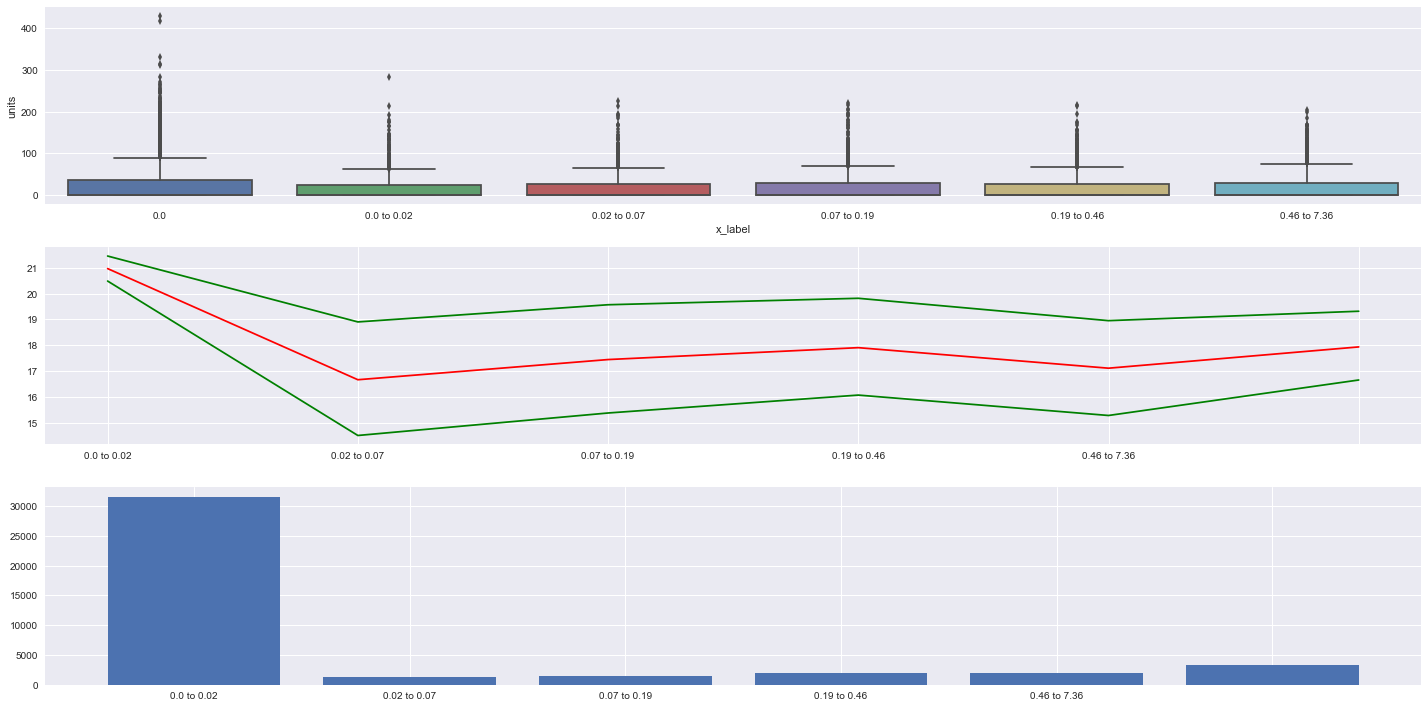

In [184]:
import seaborn as sns

def bsfromfunc(observes,targetfunc):
    value = targetfunc(observes)
    bs_target = np.empty(10000)
    for i in range(10000):
        bs_sample = np.random.choice(observes,size=len(observes))
        bs_target[i] = targetfunc(bs_sample)
        
    print 'value, ', value
    print '99% interval, ', np.percentile(bs_target, [0.5, 99.5])
    
    return value,np.percentile(bs_target, [0.5, 99.5])

def cont_boxplot(data,xlabel,ylabel,seg=10):
    data_range = np.percentile(data[xlabel], [100*float(x)/seg for x in range(seg+1)])
    data_range = sorted(list(set(data_range)))
    
    print data_range
    
    seg = len(data_range) - 1
    data['x_label']=str(data_range[seg-1])+' to '+str(data_range[seg])
    value = []
    value_interv_h = []
    value_interv_l = []
    number = []
    order = []
    
    data.loc[(data[xlabel]==data_range[0]),'x_label'] = str(data_range[0])
    obsers = data.loc[data['x_label']==str(data_range[0]),ylabel]
    print '\n'+'for '+xlabel+' range in '+str(data_range[0])
    print 'number of observations: '+str(len(obsers))
    t_value,t_interv = bsfromfunc(obsers,np.mean)
    value.append(t_value)
    value_interv_l.append(t_interv[0])
    value_interv_h.append(t_interv[1])
    number.append(len(obsers))
    order.append(str(data_range[0]))
    for i in range(seg):
        data.loc[(data[xlabel]>data_range[i])&(data[xlabel]<data_range[i+1]),'x_label']=str(data_range[i])+' to '+str(data_range[i+1])
        obsers = data.loc[data['x_label']==str(data_range[i])+' to '+str(data_range[i+1]),ylabel]
        print '\n'+'for '+xlabel+' range in '+str(data_range[i])+' to '+str(data_range[i+1])
        print 'number of observations: '+str(len(obsers))
        t_value,t_interv = bsfromfunc(obsers,np.mean)
        value.append(t_value)
        value_interv_l.append(t_interv[0])
        value_interv_h.append(t_interv[1])
        number.append(len(obsers))
        order.append(str(data_range[i])+' to '+str(data_range[i+1]))
    f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,10))
    sns.boxplot(x='x_label',y=ylabel,data=data,ax=ax1,order=order)
    #ax1.set_xticklabels(data['x_label'],rotation='vertical')
    
    ax2.plot(value,c='red')
    ax2.plot(value_interv_l,c='green')
    ax2.plot(value_interv_h,c='green')
    ax2.plot()
    ax2.set_xticklabels(order)
    
    #ax2.plot(number)
    ax3.bar(np.array(np.arange(len(number))), np.array(number), width=0.8)
    ax3.set_xticklabels(order)
    plt.tight_layout()
    plt.show()
    #return value, value_interv_l, value_interv_h
    
mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','preciptotal']]
cont_boxplot(data,'preciptotal','units',seg=20)

In [181]:
np.percentile(data['preciptotal'],[10,20,30,40,50,60])

array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
mask = ((df_severeWeather['item_nbr'] == 5) & (df_severeWeather['Condition']))
data = df_severeWeather.loc[mask,['units','preciptotal']]

plt.scatter(data['preciptotal'],data['units'])
plt.show()

In [ ]:
cont_boxplot(data,'preciptotal','units',seg=6)

In [172]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]